In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import boxcox
from sklearn.metrics import cohen_kappa_score
import lightgbm as ltb
from sklearn import svm
from sklearn.metrics import cohen_kappa_score
from catboost import CatBoostClassifier

In [69]:
df = pd.read_csv("/kaggle/input/playground-series-season-3-episode-5/train.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-season-3-episode-5/sample_submission.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-season-3-episode-5/test.csv")

In [70]:
# df1 = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")
# df1 = df1[(df1['quality'] == 3) | (df1['quality'] == 4) | (df1['quality'] == 8)]
# df = pd.concat([df,df1])

In [71]:
dff = df.copy()
dff_test = df_test.copy()

In [72]:
# dff = df.drop(["Id"], axis = 1)
# df = dff[(dff["quality"] == 3) | (dff["quality"] == 4) | (dff["quality"] == 8)]
# plt.figure(figsize = (30, 30))
# sns.pairplot(data = df, hue = 'quality',palette = {3:"red", 4:"blue",8:"green"})

In [73]:
#df = pd.concat([df, dff], axis = 0)
df = df.drop("Id", axis = 1)
df_test = df_test.drop("Id", axis = 1)
df = df.drop_duplicates()
df = df.reset_index(drop = True)

In [74]:
#df = pd.concat([df, dff], axis = 0)
dff = dff.drop("Id", axis = 1)
dff_test = dff_test.drop("Id", axis = 1)
dff = dff.drop_duplicates()
dff = dff.reset_index(drop = True)

No NULL value in this dataset nice nice

<AxesSubplot:xlabel='quality', ylabel='count'>

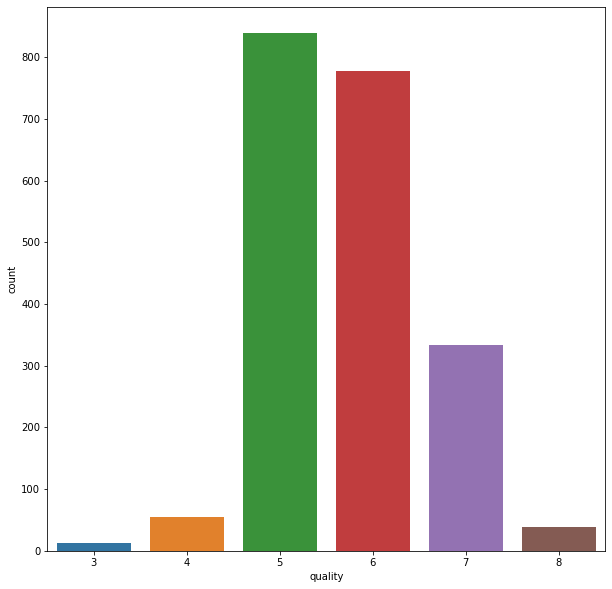

In [75]:
plt.figure(figsize=(10,10))
sns.countplot(data = df, x = "quality")

In [76]:
def feature_engineering(df):
    quality_mapping = {3:0, 4:1, 5:2, 6:3, 7:4, 8:5}
    df.loc[:, "quality"] = df.quality.map(quality_mapping)
    return df

In [77]:
def feature_engineering_dff(df):
    quality_mapping = {3:0, 4:1, 5:2, 6:3, 7:4, 8:5}
    df.loc[:, "quality"] = df.quality.map(quality_mapping)
    
    df["total sulfur dioxide"] = df["total sulfur dioxide"].apply(lambda x : np.log(1 + x))
    df["free sulfur dioxide"] = df["free sulfur dioxide"].apply(lambda x : np.log(1 + x))
    df["citric acid"] = df["citric acid"].apply(lambda x : np.log(1 + x))
    df["alcohol"] = df["alcohol"].apply(lambda x : np.log(1 + x))
    
    df["citric acid"] = df["citric acid"].apply(lambda x : np.log(1 + x))

    for i in ["total sulfur dioxide","free sulfur dioxide", "alcohol"]:
        bcx_target, lam = boxcox(df[i])
        df[i] = bcx_target
    
    df["total sulfur dioxide - free sulfur dioxide"] = df["total sulfur dioxide"] - df["free sulfur dioxide"]
    df["residual sugar * chlorides"] = df["residual sugar"] * df["chlorides"]
    df["fixed acidity + volatile acidity"] = df["fixed acidity"] + df["volatile acidity"]
    df["residual sugar * density"] = df["residual sugar"] * df["density"]
    
    
    pf = preprocessing.PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
    poly_feats = pf.fit_transform(df.drop(["quality"], axis=1))
    num_feats = poly_feats.shape[1]
    df_tranformed = pd.DataFrame(poly_feats, 
                            columns = [f"f_{i}" for i in range(1, num_feats + 1)])
    df = pd.concat([df_tranformed, df.quality],axis = 1)
    
    for i in df.columns:
        if i != "quality":
            df["{}_bined".format(i)] = pd.cut(df[i], bins = 5, labels = False)
    
    
  
    
    return df

In [78]:
def make_fold(df, fold):
    df["kfold"] = -1
    df.sample(frac=1).reset_index(drop = True)
    y = df.quality.values
    kf = model_selection.StratifiedKFold(n_splits = fold)
    for f, (t_,v_) in enumerate(kf.split(X = df, y = y)):
        df.loc[v_, 'kfold'] = f
    return df

In [79]:
df = feature_engineering(df)
df = make_fold(df, 5)

In [80]:
df_test["quality"] = 0
df_test = feature_engineering(df_test)

In [81]:
dff = feature_engineering_dff(dff)
dff = make_fold(dff, 5)
dff_test["quality"] = 0
dff_test = feature_engineering_dff(dff_test)

In [82]:
cols = list(df.columns)
cols.remove('quality')
cols.remove('kfold')

In [83]:
dffcols = list(dff.columns)
dffcols.remove('quality')
dffcols.remove('kfold')

In [84]:
#inference

fold_train = 0
fold_test = 0
fold = 5
test_list = []
for i in tqdm(range(fold)):
    df_train = df[df['kfold'] != i]
    df_eval = df[df['kfold'] == i]
#     model = CatBoostClassifier(  
#                                  random_state=66,
#                                  early_stopping_rounds=20,
#                                  task_type='GPU',
#                                  bootstrap_type='Poisson',
#                                  loss_function='MultiClass')
    model = CatBoostClassifier(  
                                 random_state=66,
                                 early_stopping_rounds=20,
                                 task_type='GPU',
                                 learning_rate= 0.750683997836041,
                                 depth = 2,
                                 l2_leaf_reg = 0.7913865351669737,
                                 subsample = 0.5309678019732926,
                                 iterations = 298,
                                 bootstrap_type='Poisson',
                                 loss_function='MultiClass')
    
    model.fit(df_train[cols], df_train.quality, eval_set=[(df_eval[cols],df_eval.quality)], verbose=True)    

    test_predictions = model.predict(df_test[cols]) 
    test_list.append(test_predictions)

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 1.1541821	test: 1.1775132	best: 1.1775132 (0)	total: 14.4ms	remaining: 4.28s
1:	learn: 1.0567527	test: 1.0658295	best: 1.0658295 (1)	total: 25.3ms	remaining: 3.74s
2:	learn: 1.0358791	test: 1.0504959	best: 1.0504959 (2)	total: 45.9ms	remaining: 4.51s
3:	learn: 1.0124808	test: 1.0408940	best: 1.0408940 (3)	total: 61.6ms	remaining: 4.53s
4:	learn: 1.0084816	test: 1.0368500	best: 1.0368500 (4)	total: 72ms	remaining: 4.22s
5:	learn: 0.9998576	test: 1.0333103	best: 1.0333103 (5)	total: 81.9ms	remaining: 3.99s
6:	learn: 0.9969607	test: 1.0304499	best: 1.0304499 (6)	total: 92ms	remaining: 3.82s
7:	learn: 0.9928165	test: 1.0312076	best: 1.0304499 (6)	total: 103ms	remaining: 3.72s
8:	learn: 0.9880693	test: 1.0317533	best: 1.0304499 (6)	total: 113ms	remaining: 3.62s
9:	learn: 0.9826975	test: 1.0301906	best: 1.0301906 (9)	total: 123ms	remaining: 3.54s
10:	learn: 0.9739641	test: 1.0319786	best: 1.0301906 (9)	total: 133ms	remaining: 3.48s
11:	learn: 0.9716331	test: 1.0339822	best: 1.03019

 20%|██        | 1/5 [00:00<00:03,  1.06it/s]

0:	learn: 1.1554223	test: 1.1917519	best: 1.1917519 (0)	total: 22.1ms	remaining: 6.58s
1:	learn: 1.0657127	test: 1.0719684	best: 1.0719684 (1)	total: 44.2ms	remaining: 6.54s
2:	learn: 1.0460376	test: 1.0527639	best: 1.0527639 (2)	total: 66.4ms	remaining: 6.53s
3:	learn: 1.0320059	test: 1.0453215	best: 1.0453215 (3)	total: 98.4ms	remaining: 7.23s
4:	learn: 1.0143495	test: 1.0233412	best: 1.0233412 (4)	total: 129ms	remaining: 7.55s
5:	learn: 1.0066446	test: 1.0228335	best: 1.0228335 (5)	total: 148ms	remaining: 7.22s
6:	learn: 0.9958840	test: 1.0134233	best: 1.0134233 (6)	total: 170ms	remaining: 7.08s
7:	learn: 0.9918789	test: 1.0158752	best: 1.0134233 (6)	total: 191ms	remaining: 6.93s
8:	learn: 0.9822276	test: 1.0165056	best: 1.0134233 (6)	total: 214ms	remaining: 6.86s
9:	learn: 0.9778973	test: 1.0179987	best: 1.0134233 (6)	total: 238ms	remaining: 6.85s
10:	learn: 0.9716245	test: 1.0190275	best: 1.0134233 (6)	total: 260ms	remaining: 6.78s
11:	learn: 0.9671357	test: 1.0244026	best: 1.0134

 40%|████      | 2/5 [00:02<00:03,  1.19s/it]

0:	learn: 1.1479424	test: 1.1354229	best: 1.1354229 (0)	total: 27.4ms	remaining: 8.14s
1:	learn: 1.0930847	test: 1.0949500	best: 1.0949500 (1)	total: 52.7ms	remaining: 7.8s
2:	learn: 1.0666272	test: 1.0575679	best: 1.0575679 (2)	total: 74.9ms	remaining: 7.36s
3:	learn: 1.0313290	test: 1.0285178	best: 1.0285178 (3)	total: 98.9ms	remaining: 7.27s
4:	learn: 1.0184255	test: 1.0220387	best: 1.0220387 (4)	total: 137ms	remaining: 8.05s
5:	learn: 1.0068297	test: 1.0189853	best: 1.0189853 (5)	total: 182ms	remaining: 8.86s
6:	learn: 0.9948330	test: 1.0095123	best: 1.0095123 (6)	total: 216ms	remaining: 8.98s
7:	learn: 0.9892044	test: 1.0067226	best: 1.0067226 (7)	total: 252ms	remaining: 9.13s
8:	learn: 0.9805290	test: 0.9962635	best: 0.9962635 (8)	total: 284ms	remaining: 9.12s
9:	learn: 0.9721473	test: 0.9976606	best: 0.9962635 (8)	total: 313ms	remaining: 9.03s
10:	learn: 0.9672606	test: 1.0058868	best: 0.9962635 (8)	total: 345ms	remaining: 9s
11:	learn: 0.9636668	test: 1.0073643	best: 0.9962635 

 60%|██████    | 3/5 [00:03<00:02,  1.40s/it]

0:	learn: 1.1377342	test: 1.1901337	best: 1.1901337 (0)	total: 21.2ms	remaining: 6.31s
1:	learn: 1.0636081	test: 1.1513346	best: 1.1513346 (1)	total: 38.1ms	remaining: 5.64s
2:	learn: 1.0466448	test: 1.1476363	best: 1.1476363 (2)	total: 55.5ms	remaining: 5.46s
3:	learn: 1.0086006	test: 1.0929440	best: 1.0929440 (3)	total: 73.2ms	remaining: 5.38s
4:	learn: 0.9899278	test: 1.1030034	best: 1.0929440 (3)	total: 91.9ms	remaining: 5.38s
5:	learn: 0.9791250	test: 1.1008987	best: 1.0929440 (3)	total: 112ms	remaining: 5.43s
6:	learn: 0.9632367	test: 1.1055177	best: 1.0929440 (3)	total: 130ms	remaining: 5.42s
7:	learn: 0.9508305	test: 1.1122272	best: 1.0929440 (3)	total: 150ms	remaining: 5.45s
8:	learn: 0.9433114	test: 1.1187794	best: 1.0929440 (3)	total: 168ms	remaining: 5.39s
9:	learn: 0.9375222	test: 1.1294931	best: 1.0929440 (3)	total: 186ms	remaining: 5.35s
10:	learn: 0.9332091	test: 1.1382304	best: 1.0929440 (3)	total: 206ms	remaining: 5.37s
11:	learn: 0.9290050	test: 1.1337245	best: 1.092

 80%|████████  | 4/5 [00:05<00:01,  1.29s/it]

0:	learn: 1.1498421	test: 1.1347472	best: 1.1347472 (0)	total: 22.3ms	remaining: 6.62s
1:	learn: 1.0855377	test: 1.0703413	best: 1.0703413 (1)	total: 42.3ms	remaining: 6.26s
2:	learn: 1.0607143	test: 1.0399657	best: 1.0399657 (2)	total: 61.8ms	remaining: 6.08s
3:	learn: 1.0244643	test: 1.0123999	best: 1.0123999 (3)	total: 82.7ms	remaining: 6.08s
4:	learn: 1.0131100	test: 1.0007234	best: 1.0007234 (4)	total: 104ms	remaining: 6.11s
5:	learn: 1.0051828	test: 0.9997201	best: 0.9997201 (5)	total: 124ms	remaining: 6.05s
6:	learn: 0.9931301	test: 0.9917959	best: 0.9917959 (6)	total: 140ms	remaining: 5.81s
7:	learn: 0.9863265	test: 0.9832069	best: 0.9832069 (7)	total: 160ms	remaining: 5.79s
8:	learn: 0.9827429	test: 0.9830028	best: 0.9830028 (8)	total: 177ms	remaining: 5.67s
9:	learn: 0.9790498	test: 0.9857784	best: 0.9830028 (8)	total: 193ms	remaining: 5.56s
10:	learn: 0.9760595	test: 0.9829959	best: 0.9829959 (10)	total: 213ms	remaining: 5.55s
11:	learn: 0.9702804	test: 0.9801951	best: 0.980

100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


In [85]:
dff_test

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_111_bined,f_112_bined,f_113_bined,f_114_bined,f_115_bined,f_116_bined,f_117_bined,f_118_bined,f_119_bined,f_120_bined
0,7.2,0.510,0.009901,2.0,0.077,3.793120,3.449054,0.99748,3.39,0.59,...,0,0,1,0,1,1,1,0,0,0
1,7.2,0.755,0.130819,2.0,0.102,2.381030,2.925064,0.99586,3.33,0.68,...,1,0,1,0,2,2,2,0,0,0
2,8.4,0.460,0.290033,2.0,0.065,3.070828,3.355023,0.99774,3.08,0.65,...,1,0,1,0,1,1,2,0,0,0
3,8.0,0.470,0.290033,1.8,0.056,2.381030,2.529314,0.99480,3.30,0.65,...,1,0,1,0,1,1,1,0,0,0
4,6.5,0.340,0.245008,2.1,0.044,1.542544,4.137827,0.99356,3.23,0.48,...,4,0,0,0,2,3,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,8.8,0.745,0.153163,2.7,0.084,4.345345,4.392903,0.99823,3.38,0.70,...,1,0,1,1,1,1,1,0,0,1
1368,15.6,0.240,0.363431,2.9,0.062,2.002890,2.529314,0.99724,2.99,0.77,...,1,0,4,1,2,2,2,1,0,2
1369,7.3,0.760,0.000000,2.2,0.095,1.166685,2.214774,0.99880,3.67,0.60,...,2,0,1,0,2,2,2,0,0,0
1370,7.6,0.780,0.207918,2.6,0.118,2.703117,4.265437,0.99616,3.30,0.53,...,3,1,1,0,3,3,2,1,0,0


In [86]:
#inference

fold_train = 0
fold_test = 0
fold = 5
testdff_list = []
for i in tqdm(range(fold)):
    dff_train = dff[dff['kfold'] != i]
    model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2', C = 1)
    model.fit(dff_train[dffcols], dff_train.quality)  

    test_predictions = model.predict(dff_test[dffcols]) 
    testdff_list.append(test_predictions)

100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


In [87]:
# #inference2

# fold_train = 0
# fold_test = 0
# fold = 1
# test_list = []
# for i in tqdm(range(fold)):
#     #df_train = df[df['kfold'] != i]
#     df_train = df
#     model = ltb.LGBMClassifier()
#     model.fit(df_train[cols], df_train.quality)
#     test_predictions = model.predict(df_test[cols]) 
#     test_list.append(test_predictions)

# pred = test_predictions
# #test_array = np.array(test_list)
# #pred = [*map(lambda x : np.argmax(np.bincount(x)), test_array.T)]

In [88]:
pd.DataFrame(testdff_list).describe()

,0,1,2,3,4,5,6,7,8,9,...,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371
count,5.0,5.000000,5.000000,5.0,5.0,5.0,5.0,5.000000,5.0,5.0,...,5.0,5.0,5.000000,5.0,5.000000,5.0,5.0,5.0,5.0,5.0
mean,2.0,2.800000,2.200000,3.0,3.0,3.0,3.0,2.800000,3.0,2.0,...,3.0,2.0,2.200000,4.0,3.200000,2.0,4.0,2.0,2.0,2.0
std,0.0,0.447214,0.447214,0.0,0.0,0.0,0.0,0.447214,0.0,0.0,...,0.0,0.0,0.447214,0.0,0.447214,0.0,0.0,0.0,0.0,0.0
min,2.0,2.000000,2.000000,3.0,3.0,3.0,3.0,2.000000,3.0,2.0,...,3.0,2.0,2.000000,4.0,3.000000,2.0,4.0,2.0,2.0,2.0
25%,2.0,3.000000,2.000000,3.0,3.0,3.0,3.0,3.000000,3.0,2.0,...,3.0,2.0,2.000000,4.0,3.000000,2.0,4.0,2.0,2.0,2.0
50%,2.0,3.000000,2.000000,3.0,3.0,3.0,3.0,3.000000,3.0,2.0,...,3.0,2.0,2.000000,4.0,3.000000,2.0,4.0,2.0,2.0,2.0
75%,2.0,3.000000,2.000000,3.0,3.0,3.0,3.0,3.000000,3.0,2.0,...,3.0,2.0,2.000000,4.0,3.000000,2.0,4.0,2.0,2.0,2.0
max,2.0,3.000000,3.000000,3.0,3.0,3.0,3.0,3.000000,3.0,2.0,...,3.0,2.0,3.000000,4.0,4.000000,2.0,4.0,2.0,2.0,2.0


In [89]:
testdff_list

[array([2, 3, 3, ..., 2, 2, 2]),
 array([2, 3, 2, ..., 2, 2, 2]),
 array([2, 3, 2, ..., 2, 2, 2]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([2, 3, 2, ..., 2, 2, 2])]

In [90]:
np.array(testdff_list)

array([[2, 3, 3, ..., 2, 2, 2],
       [2, 3, 2, ..., 2, 2, 2],
       [2, 3, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 3, 2, ..., 2, 2, 2]])

In [91]:
a = np.array([1,2,3])

In [92]:
a.reshape((1, -1))

array([[1, 2, 3]])

In [93]:
new_list = []

for i in test_list:
    new_list.append(i.flatten())

for i,k in enumerate(new_list):
    k = k.reshape((1, -1))
    print(k)
    if i ==0:
        p = k
    else:
        p = np.concatenate((p,k),axis = 0)


[[2 3 2 ... 2 2 2]]
[[2 3 2 ... 2 2 3]]
[[2 3 3 ... 2 2 2]]
[[2 3 3 ... 2 2 3]]
[[2 3 3 ... 2 2 2]]


In [94]:
# p = np.concatenate((p,np.array(testdff_list)),axis = 0)

In [96]:

pred = [*map(lambda x : np.argmax(np.bincount(x)), p.T)]

In [99]:
sample_submission.loc[:, "quality"] = pred
quality_mapping = {0:3, 1:4, 2:5, 3:6, 4:7, 5:8}
sample_submission.loc[:, "quality"] = sample_submission.quality.map(quality_mapping)
sample_submission.to_csv("/kaggle/working/sample_submission13.csv",index=False)

<AxesSubplot:xlabel='quality', ylabel='count'>

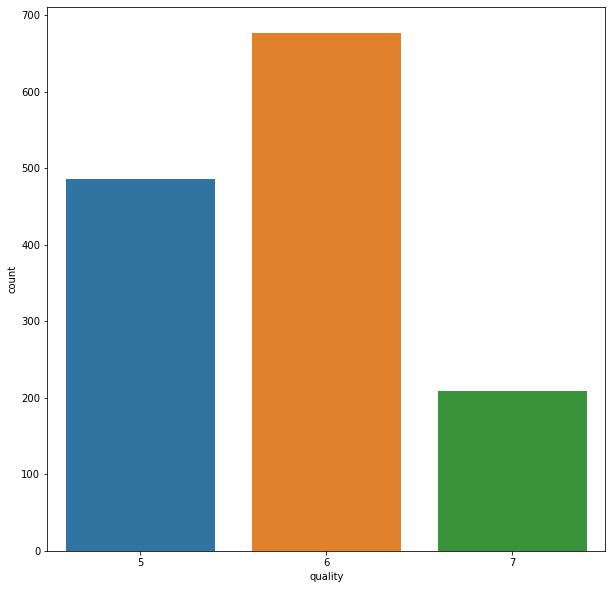

In [100]:
plt.figure(figsize = (10,10))
sns.countplot(data = sample_submission, x = 'quality')